In [ ]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 781.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.1 MB/s eta 0:00:00


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds


In [ ]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image_gallery(images, titles=None, num_cols=3, figsize=(10, 10)):
    # Ensure images are in the correct format for display
    images = images.numpy()  # Convert tensor to NumPy array

    num_images = images.shape[0]
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot each image individually
            ax.imshow(images[i])  # Display each image
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=10)
        else:
            ax.axis("off")  # Turn off axis if there are more subplots than images

    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

# Load your dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'       # 'int' for integer labels, or 'categorical' for one-hot encoded labels
)

# Get the number of classes from the training dataset
num_classes = len(train_dataset.class_names)
print("Classes found:", train_dataset.class_names)  # Optional: To verify class names

# Define resizing layer
resizing = keras.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

def preprocess_inputs(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize if not already done
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Preprocess, shuffle, and batch the dataset
# Preprocess, shuffle, but do not batch again
train_dataset = train_dataset.map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(10 * BATCH_SIZE, reshuffle_each_iteration=True)



Found 32 files belonging to 4 classes.
Classes found: ['KO', 'OK', 'RzKO', 'RzOK']


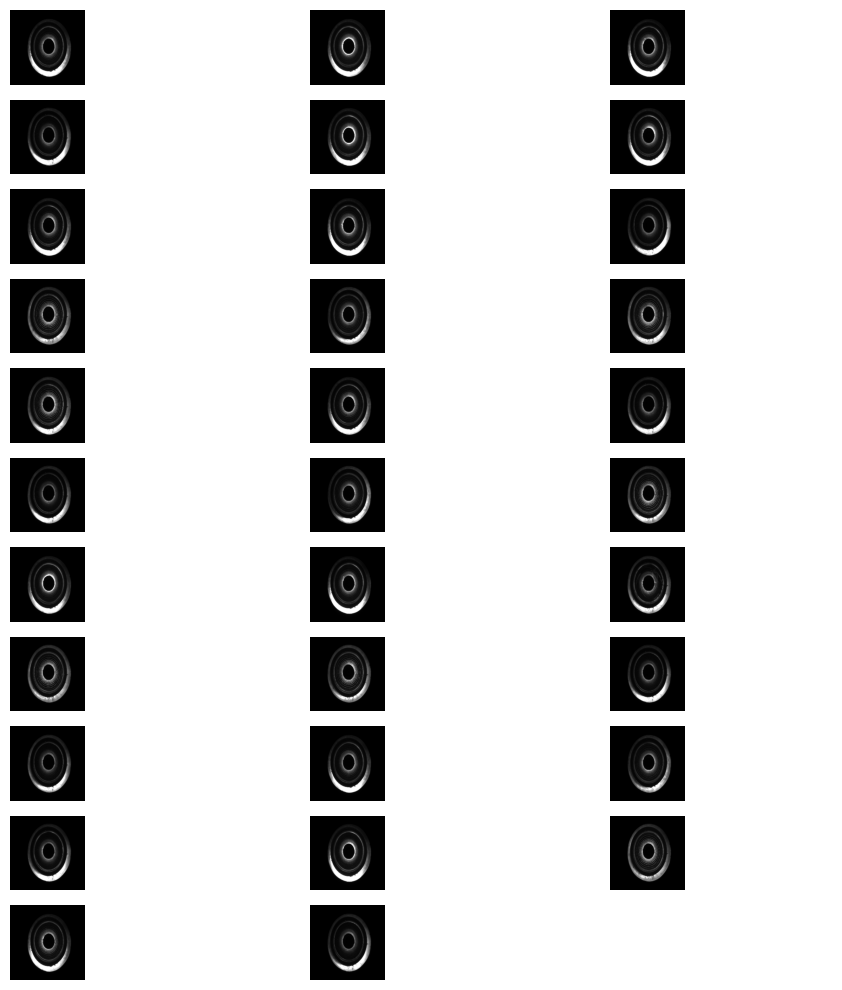

In [ ]:
images = next(iter(train_dataset.take(1)))[0]
plot_image_gallery(images)

In [ ]:
model = keras_hub.models.ImageClassifier.from_preset(
    "resnet_v2_50_imagenet", num_classes=4
)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

In [ ]:
model.fit(train_dataset , epochs=5)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 64s 64s/step - accuracy: 0.4062 - loss: 6.8328
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - accuracy: 0.2188 - loss: 6.1737
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.2500 - loss: 5.3751
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.2500 - loss: 4.8027
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.2500 - loss: 4.7928


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving RzKO16_02.bmp to RzKO16_02.bmp


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Get the file name of the uploaded image
file_name = list(uploaded.keys())[0]

# Load the image, resize to 224x224, and preprocess
image = tf.keras.preprocessing.image.load_img(file_name, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)  # Convert to array
image = image / 255.0  # Normalize to [0, 1] range
image = np.expand_dims(image, axis=0)  # Add batch dimension, making shape (1, 224, 224, 3)

# Predict using the model
predictions = model.predict(image)

# Map prediction indices to class labels
classes = {0: "KO", 1: "OK", 2: "RzKO", 3: "RzOK"}
top_class_index = predictions[0].argmax()  # Get the index of the highest probability
print("Top class is:", classes[top_class_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top class is: KO


In [ ]:
# Map the output indices to your class names
classes = {0: "KO", 1: "OK", 2: "RzKO", 3: "RzOK"}

# Assuming `image` is a preprocessed image ready for prediction
predictions = model.predict(image)  # If `image` is a batch, ensure it's of shape (1, 224, 224, 3)

# Print the top predicted class
top_class_index = predictions[0].argmax()  # Get the index of the highest prediction score
print("Top class is:", classes[top_class_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Top class is: KO
